# DMRG tutorial: Getting started

The aim of this tutorial is to show how the `DMRG` algorithm can be used to simulate pulser sequences.
`DMRG` can be faithfully used to simulate adiabatic pulser sequences. It can also be used for more general tasks, e.g. finding the ground state of a specific Hamiltonian.

For more information about the DMRG solver, please refer to the DMRG documentation[I need to put the documentation here]

Let us import the ingredients needed to run a pulser simulation using the `DMRG` solver
- `MPS`: used to construct a matrix product state
- `MPSConfig`: used to configure the emu-mps MPSBackend
- `MPSBackend`: used as a backend to simulate pulser sequences using MPS
- `Bitstrings`, `Fidelity`, `Occupation`: observables that can be extracted at specific `evaluation times` during time evolution
- `Solver`: used to choose the particular solver for a specific simulation. Two solvers are currently supported: `TDVP` (default) and `DMRG`.
- `pulser`: needed to create the Pulser experiment (creating the register, laser and pulse sequences).

In [2]:
import matplotlib.pyplot as plt
from emu_mps.mps import MPS
from emu_mps import (
    MPS,
    MPSConfig,
    MPSBackend,
    BitStrings,
    Fidelity,
    Occupation,
)
from emu_mps.solver import Solver
import math
import pulser
from pulser.devices import AnalogDevice
import numpy as np

## Running a simulation using emu-mps

Emu-mps is a Pulser backend, designed to `Emulate` the dynamics of programmable arrays of neutral atoms.
The simulation takes place using the method `run`, which requires two arguments:
- a valid Pulser sequence
- a configuration file

The following Notebook provides a step-by-step guide to be able to trigger the `DMRG` algorithm to simulate an AFM sequence. Below you find the workflow necessary to build the experiment successfully: 
1. Create the atomic `register` using Pulser
2. Design a pulse sequence (`sequence`) that produces the AFM state for the given register
3. Create an `MPSConfig` object (`MPSConfig_obj`), and add the observables that you wish to study, along with other parameters such as the time step
4. Instantiate the backend class (`MPSBackend`) to run the simulation
5. Run the simulation using `run(sequence, MPSConfig_obj)`
5. Print the results.

### Register and Sequence creation

To make this tutorial focused on the backend functionalities we use two auxiliary functions to quickly create the Pulser object. 

The function `square_perimeter_points` calculates the coordinates of the atoms located on the perimeter of a square. 
The qubits will be labeled starting from the bottom-left corner and moving counter-clockwise around the square. Please, notice that the measured bitstrings will depend on the order chosen for the atom locations.

The function `afm_sequence_from_register` creates the pulse sequence for the AFM state for the specified register. The sequence will consist of three phases: a rise, a sweep, and a fall where the sweep time is proportional to the rise and fall times. 

In [3]:
def afm_sequence_from_register(
    reg: pulser.Register,
    Omega_max: float,
    delta_0: float,
    delta_f: float,
    t_rise: float,
    t_fall: float,
    factor_sweep: int,
    device: pulser.devices = pulser.devices.MockDevice,
) -> pulser.Sequence:
    """Sequence that creates AntiFerromagnetic State (AFM) for 1d chain of atoms using pulser.
    This function constructs a sequence of pulses to transition a system of qubits
    distributed in a 1d chain (represented by `reg`) into an AFM state using a specified device.
    The sequence consists of three phases: a rise, a sweep, and a fall.
    For more information, check Pulser
    [tutorial](https://pulser.readthedocs.io/en/stable/tutorials/afm_prep.html)."""

    t_sweep = (delta_f - delta_0) / (2 * np.pi * 10) * 1000 * factor_sweep
    rise = pulser.Pulse.ConstantDetuning(
        pulser.waveforms.RampWaveform(t_rise, 0.0, Omega_max), delta_0, 0.0
    )
    sweep = pulser.Pulse.ConstantAmplitude(
        Omega_max, pulser.waveforms.RampWaveform(t_sweep, delta_0, delta_f), 0.0
    )
    fall = pulser.Pulse.ConstantDetuning(
        pulser.waveforms.RampWaveform(t_fall, Omega_max, 0.0), delta_f, 0.0
    )

    seq = pulser.Sequence(reg, device)
    seq.declare_channel("ising_global", "rydberg_global")
    seq.add(rise, "ising_global")
    seq.add(sweep, "ising_global")
    seq.add(fall, "ising_global")

    return seq


def square_perimeter_points(L: int) -> np.ndarray:
    """
    Calculate the coordinates of the points located on the perimeter of a square of size L.
    The square is centered at the origin (0, 0) with sides parallel to the axes.
    The points are ordered starting from the bottom-left corner and moving
    counter-clockwise around the square. The order is important when measuare the bitstrings

    Args:
        L (int): The length of the side of the square. L should be a positive integer.

    Returns:
        np.ndarray: An array of shape (4*L-4, 2) containing the coordinates of the perimeter points.

    Example:
        >>> square_perimeter_points(3)
        array([[-1, -1],
               [-1,  0],
               [-1,  1],
               [ 0,  1],
               [ 1,  1],
               [ 1,  0],
               [ 1, -1],
               [ 0, -1]])
    """
    pairOrodd = L % 2
    toGrid = int(math.floor(L / 2))
    if pairOrodd == 0:
        axis = list(range(-toGrid, toGrid, 1))
    else:
        axis = list(range(-toGrid, toGrid + 1, 1))
    coord = []
    for i in axis:  # from left, first column of the perimeter
        coord.append([axis[0], i])

    for i in axis[1:-1]:
        coord.append([i, axis[-1]])

    for i in reversed(axis):
        coord.append([axis[-1], i])

    for i in reversed(axis[1:-1]):
        coord.append([i, axis[0]])

    return np.array(coord)


We start by defining the main physical quantities needed to prepare the system. For the reader's conveninence we recall here their meaning:
- `Omega_max` is the peak laser amplitude used in the pulse sequence
- `delta_0` is the initial detuning used in the pulse
- `delta_f` is the final detuning used in the pulse
- `t_rise` is the duration of the rise phase
- `t_fall` is the duraction of the fall phase
- `sweep_factor` is a scale factor expressing the duration of the sweep phase in terms of `delta_f - delta_0`
Note that we make the interatomic distance depend on `Omega_max` so that the interaction strength in the system is relative to the pulse parameters.

In [4]:
Omega_max = 2 * 2 * np.pi
delta_0 = -6 * Omega_max / 2
delta_f = 1 * Omega_max / 2
t_rise = 500
t_fall = 1500
sweep_factor = 2

square_length = 3
R_interatomic = AnalogDevice.rydberg_blockade_radius(Omega_max / 2)

As discussed above, we start with the first step:

`Create the atomic register using Pulser`. This register is a square of 8 atoms

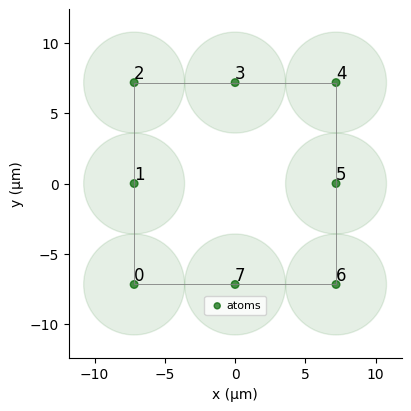

In [6]:
coords = R_interatomic * square_perimeter_points(square_length)
reg = pulser.Register.from_coordinates(coords)
reg.draw(blockade_radius=R_interatomic, draw_graph=True, draw_half_radius=True)

Then, we proceed to the next step:

`Design a pulse sequence (sequence) that produces the AFM state for the given register`

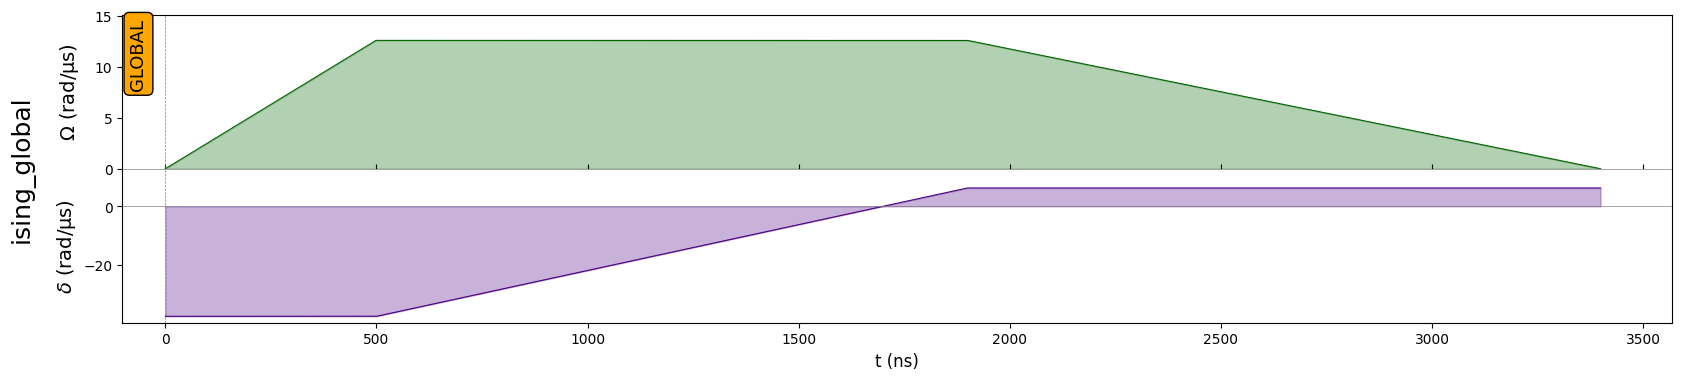

In [7]:
seq = afm_sequence_from_register(
    reg, Omega_max, delta_0, delta_f, t_rise, t_fall, sweep_factor, AnalogDevice
)
seq.draw("input")

### Using emu-mps as backend

As mentioned earlier, to run a simulation with emu-mps we need to provide as input a Pulse sequence - which we have just created - and a configuration object. 

We still have to create the configuration for the emu-mps backend. This is done via an instantiation of the configuration class `MPSConfig` which contains all the observables that we wish to measure and the time step chosen for the simulation, along with various algorithm specific parameters that are explained in the documentation.

We start by setting a bigger discretization time than the default one provided ($dt=10$) and enforcing that the times at which we compute the observables are an integer multiple of $dt$. For simplicity, we will measure the observables only at the final time of the simulation.

We also fix the basis along which the measurements will be done. For the details regarding the conventions used we refer to the [Pulser documentation](https://pulser.readthedocs.io/en/stable/conventions.html).

In [8]:
dt = 100
eval_times = [1.0]

basis = ("r","g")

### Among the default observables already available in the emu-mps backend, we focus in this particular example on three:
- BitString sampling
- Fidelity of the state
- Qubit density

#### BitString samples
It samples at desired time steps the evolved state, returning the *bitStrings* in a counter

In [10]:
sampling_times = 1000
bitstrings = BitStrings(evaluation_times=eval_times, num_shots=sampling_times)

#### Fidelity

The *fidelity* is computed as $\langle \psi_{evolved} | \phi_{given} \rangle$ where 
- $\psi_{evolved}$ is the system state at desired steps
- $\phi_{given}$ is the state in which we want to project the state system.

In this tutorial we will compute the fidelity against the dominant of the two antiferromagnetic states $\phi_{given} = |rgrgrgrg>$

In [11]:
nqubits = len(seq.register.qubit_ids)

afm_string_pure = {"rgrgrgrg": 1.0}

afm_mps_state = MPS.from_state_amplitudes(
    eigenstates=basis, amplitudes=afm_string_pure
)
fidelity_mps_pure = Fidelity(evaluation_times=eval_times, state=afm_mps_state)

#### Qubit Density
It is computed as $\langle \psi_{evolved} |\frac{(1+Z_i)}{2}|\psi_{evolved}\rangle$ and often informally referred to as the *magnetization* at each atom site.

In [12]:
density = Occupation(
    evaluation_times=[x/seq.get_duration() for x in range(0, seq.get_duration(), dt)]
)

##### After choosing the observables that you wish to calculate at the evaluation times, you are ready to create the MPS configuration object.
The MPS config has the argument `solver` which takes two values:
- `Solver.DMRG` if you require the `DMRG` algorithm to run the simulation
- `Solver.TDVP` if you require the `TDVP` algorithm to run the simulation

It is important to emphasize that the default solver is `TDVP`.

In [13]:
mpsconfig = MPSConfig(
    dt=dt,
    observables=[
        bitstrings,
        fidelity_mps_pure,
        density,
    ],
    solver=Solver.DMRG,
)

### Having all the ingredients needed, it is time to run the simulation

We instantiate the backend class `MPSBackend` and use its `run` method where we pass as argument the `sequence` and the `backend configuration` objects.

In [14]:
sim = MPSBackend(seq, config=mpsconfig)
results = sim.run()

step = 1/34, χ = 2, |ψ| = 0.001 MB, RSS = 553.736 MB, Δt = 0.117 s
step = 2/34, χ = 2, |ψ| = 0.001 MB, RSS = 553.736 MB, Δt = 0.077 s
step = 3/34, χ = 2, |ψ| = 0.001 MB, RSS = 553.736 MB, Δt = 0.084 s
step = 4/34, χ = 2, |ψ| = 0.001 MB, RSS = 553.736 MB, Δt = 0.057 s
step = 5/34, χ = 4, |ψ| = 0.002 MB, RSS = 553.864 MB, Δt = 0.098 s
step = 6/34, χ = 4, |ψ| = 0.002 MB, RSS = 553.864 MB, Δt = 0.084 s
step = 7/34, χ = 4, |ψ| = 0.002 MB, RSS = 553.864 MB, Δt = 0.079 s
step = 8/34, χ = 5, |ψ| = 0.003 MB, RSS = 553.864 MB, Δt = 0.095 s
step = 9/34, χ = 5, |ψ| = 0.004 MB, RSS = 553.864 MB, Δt = 0.082 s
step = 10/34, χ = 5, |ψ| = 0.004 MB, RSS = 553.864 MB, Δt = 0.083 s
step = 11/34, χ = 5, |ψ| = 0.004 MB, RSS = 553.864 MB, Δt = 0.045 s
step = 12/34, χ = 5, |ψ| = 0.004 MB, RSS = 553.864 MB, Δt = 0.052 s
step = 13/34, χ = 6, |ψ| = 0.004 MB, RSS = 553.992 MB, Δt = 0.039 s
step = 14/34, χ = 6, |ψ| = 0.004 MB, RSS = 553.992 MB, Δt = 0.053 s
step = 15/34, χ = 7, |ψ| = 0.005 MB, RSS = 553.992 MB, Δt

During simulation time one has access to the following information: 
- step: the whole sequence is discretized by dt and this generates a number of steps. 
- $\chi$ : is the bond dimension
- $|\Psi|$: memory footprint
- RSS: max memory allocation
- $\triangle t$: time that the step took to run

## Inspecting the result object

In the following lines, we are going to give a brief code examples of how you can get the information from the results object

In [15]:
results.get_result_tags()

['occupation', 'statistics', 'bitstrings', 'fidelity']

Notice that the fidelity name contains an index, because it is possible to create several fidelities on different states, and the names must be unique.

#### Bitstrings analysis

Below, we retrieve the bistrings computed.
We observe that they were indeed computed only at a single time $ns = 3400$, and we find those that were sampled the highest number of times with their relative counting.

In [ ]:
results.get_result_times(bitstrings)
bitstrings_final = results.get_result(bitstrings, 1.0)

max_val = max(bitstrings_final.values())  # max number of counts in the bitstring
max_string = [key for key, value in bitstrings_final.items() if value == max_val]
print(
    "The most frequent bitstring is {} which was sampled {} times".format(
        max_string, max_val
    )
)

filtered_counts = [count for count in bitstrings_final.values() if count > 20]
filtered_bitstrings = [
    bitstring for bitstring, count in bitstrings_final.items() if count > 20
]
x_labels = range(len(filtered_bitstrings))
with plt.style.context("seaborn-v0_8-darkgrid"):
    fig, ax = plt.subplots()
    ax.bar(x_labels, filtered_counts, color="teal", alpha=0.8)
    ax.set_xlabel("Bitstrings")
    ax.set_ylabel("Counts")
    ax.set_title("Histogram of Bitstring Counts (Counts > 20)")
    ax.set_xticks(x_labels)
    ax.set_xticklabels(filtered_bitstrings, rotation="vertical")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    plt.tight_layout()
    plt.show()

#### Fidelity analysis

Here we compute the fidelity of the system against the two different AFM state realizations defined above.  

In [ ]:
fidelity_pure = results.get_result(fidelity_mps_pure,1.0)

print(
    "The fidelity computed for the system final state against the pure state |rgrgrgr> is {}.\nThe probability of the system being in that sate is equal to {} ".format(
        fidelity_pure, abs(fidelity_pure) ** 2
    )
)

### Evolution of the state in time

Here, we plot the time evolution of the magnetization of the system sites, and we observe how the system slowly reaches the AFM state.

In [ ]:
magnetization_values = np.array(list(results.occupation))
magnetization_times = results.get_result_times(density)

In [ ]:
fig, ax = plt.subplots(figsize=(8, 4), layout="constrained")

num_time_points, positions = magnetization_values.shape
x, y = np.meshgrid(np.arange(num_time_points), np.arange(1, positions + 1))
im = plt.pcolormesh(magnetization_times, y, magnetization_values.T, shading="auto")
ax.set_xlabel("Time [ns]")
ax.set_ylabel("Qubit")
ax.set_title("State Density")
ax.set_yticks(np.arange(1, positions + 1))
cb = fig.colorbar(im, ax=ax)